In [304]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_bvp
from scipy import special as sp
from scipy import stats
import plasmapy.mathematics
from functools import partial
import scipy.optimize as op
from scipy import fftpack
from scipy import integrate
from scipy import signal
%config InlineBackend.figure_format = 'svg'
from prettytable import PrettyTable
import quadpy

In [416]:
tem = 1
#L = 80
#k = 5*2*np.pi / L
k = 0.3
L = 2*np.pi/k
vmax = 10  # 10 * np.sqrt(tem)
nx = 1001
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.01
max_steps  = 2000
data_steps = 100
data_num = int(max_steps/data_steps)+1
d = 0.1
kappa = 5

path = './data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt(tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]

def eq4PDRK(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    v_th_kappa = np.sqrt(2-3/kappa) * np.sqrt(tem)
    zeta = wc / k /v_th_kappa
    r = 1 + (kappa/(kappa-1.5)) * 1 / k**2 / l_D**2 * ( 1 - 1/2/kappa + zeta*dispersion_function(zeta) )
    return [r.real,r.imag]

print("k = ",k)
if (kappa==0):
    s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
else:
    s=op.root(lambda w:eq4PDRK(w,k),[1,0.1])
v_p = s.x[0]/k
wr_theo = s.x[0]
wi_theo = s.x[1]
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("t_Bi = ", abs(1/np.sqrt(q*d)))

print("t_L = ", abs(1/s.x[1]))
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

data_num =  21
k =  0.3
w_r =  1.1518702546801827
w_i =  -0.04346208685321588
v_p =  3.839567515600609
t_Bi =  3.162277660168379
t_L =  23.00855923870594
limited time= 1047.1975511965977
real time =  20.0


In [417]:
def dispersion_function(zeta):
    r = 0.0
    A_kappa = (kappa)**(-1.5) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5)
    def integrand(xi):
        return  (1+xi**2/kappa)**(-kappa-1)
        #return np.exp(-xi**2)
    if zeta.imag>0:
        r = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,np.inf)[0]
    elif zeta.imag==0:
        x = 0.1
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1 = (1/np.sqrt(np.pi)) * integrate.quad(integrand,s_n,s_p, weight='cauchy',wvar=zeta.real)[0]
        real2 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = real + 1j*imag
    elif zeta.imag<0:
        x = 1e-8
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1a = -1j * quadpy.quad(lambda xi_i: integrand(s_n+1j*xi_i)/(1j*xi_i-1j*zeta.imag-x),zeta.imag,0)[0]
        real1b =  1j * quadpy.quad(lambda xi_i: integrand(s_p+1j*xi_i)/(1j*xi_i-1j*zeta.imag+x),zeta.imag,0)[0]
        real2 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1a+real1b+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = (1/np.sqrt(np.pi)) * real + 1j*imag
    return r * A_kappa

In [418]:
def fk(v, t, kappa):
    r = 0
    if(kappa == 0):
        r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r

In [419]:
progesses = np.arange(0,data_num,1)

f = []
E = []
T_x0 = []
n_x0 = []
E_x0 = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    E_temp = np.loadtxt(os.path.join(path,"E"+str(progess)))
    E.append(E_temp)
    E_x0.append(E_temp[0])
    f_temp_x0 = f_temp[0,:]
    fx_temp_x0 = np.sum(f_temp_x0)*dv
    T_temp_x0 = np.sum(v**2*f_temp_x0)*dv/fx_temp_x0
    T_x0.append(T_temp_x0)
    n_x0.append(fx_temp_x0)

In [420]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

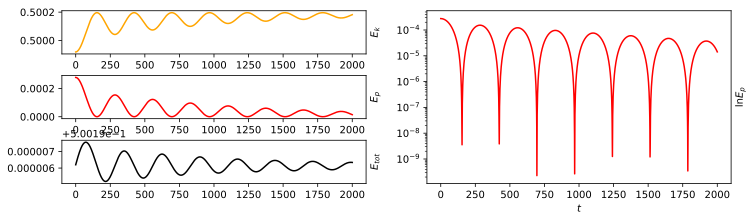

In [421]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [422]:
def line(p, x):
    k, b = p
    return k*x+b


def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r


def period(x):
    return (x[1]-x[0])/1.


def errPercent(a, b):
    r = abs((a-b)/b)*100
    return r

In [423]:
indexes, _ = signal.find_peaks(dataep, distance=5)
xep = indexes[:5]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2
wc_table=PrettyTable(['','w_r','w_i'])
wc_table.add_row(['theo',wr_theo,wi_theo])
wc_table.add_row(['sim',wr_sim,wi_sim])
wc_table.add_row(['err(%)',errPercent(wr_sim,wr_theo),errPercent(wi_sim,wi_theo)])
print(wc_table)

+--------+--------------------+----------------------+
|        |        w_r         |         w_i          |
+--------+--------------------+----------------------+
|  theo  | 1.1518702546801827 | -0.04346208685321588 |
|  sim   | 1.1549972991138944 | -0.04319303548107107 |
| err(%) | 0.2714754045437111 |  0.6190484434248916  |
+--------+--------------------+----------------------+


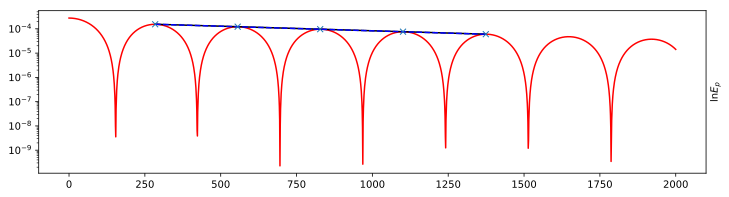

In [424]:
fig = plt.figure(figsize=(12, 3))
ax = plt.gca()
ax.plot(t, dataep, color='r')
ax.plot(xep,np.exp(line(para,xep)), '-',color='black')
ax.plot(xep,np.exp(wi_theo*xep*dt*2+para[1]), '--',color='blue')

ax.plot(xep,dataep[xep],'x')
ax.set_ylabel(r'$\ln E_p$')
ax.set_yscale('log')
ax.yaxis.set_label_position("right")
plt.show()

In [425]:
kvec = np.arange(.1,1.2,0.1)
table = PrettyTable(['k','k*l_D','w_r','w_i','v_p/v_th'])
for ki in kvec:
    s=op.root(lambda w:eq4PDRM(w,ki),[1,0.1])
    vp2vth=s.x[0]/ki/v_th
    ki4p=round(ki,6)
    kl4p=round(ki*l_D,6)
    wr4p=round(s.x[0],6)
    wi4p=round(s.x[1],6)
    vp4p=round(vp2vth,6)
    table.add_row([ki4p,kl4p,wr4p,wi4p,vp4p])
print(table)

+-----+-------+----------+-----------+----------+
|  k  | k*l_D |   w_r    |    w_i    | v_p/v_th |
+-----+-------+----------+-----------+----------+
| 0.1 |  0.1  | 1.015198 |    -0.0   | 7.178531 |
| 0.2 |  0.2  | 1.063984 |  -5.5e-05 | 3.761753 |
| 0.3 |  0.3  | 1.159846 |  -0.01262 | 2.733784 |
| 0.4 |  0.4  | 1.285057 | -0.066128 | 2.271681 |
| 0.5 |  0.5  | 1.415662 | -0.153359 | 2.002048 |
| 0.6 |  0.6  | 1.545707 |  -0.26411 | 1.821633 |
| 0.7 |  0.7  | 1.673866 | -0.392401 | 1.69086  |
| 0.8 |  0.8  | 1.799899 | -0.534552 | 1.590901 |
| 0.9 |  0.9  | 1.923865 | -0.688109 | 1.511531 |
| 1.0 |  1.0  | 2.045905 |  -0.85133 | 1.446673 |
| 1.1 |  1.1  | 2.166175 | -1.022919 | 1.39247  |
+-----+-------+----------+-----------+----------+


In [343]:
table_kappa = PrettyTable(['k','k*l_D','w_r','w_i','v_p/v_th'])
for ki in kvec:
    s=op.root(lambda w:eq4PDRK(w,ki),[1,0.1])
    vp2vth=s.x[0]/ki/v_th
    ki4p=round(ki,6)
    kl4p=round(ki*l_D,6)
    wr4p=round(s.x[0],6)
    wi4p=round(s.x[1],6)
    vp4p=round(vp2vth,6)
    table_kappa.add_row([ki4p,kl4p,wr4p,wi4p,vp4p])
print(table_kappa)

+-----+-------+----------+-----------+----------+
|  k  | k*l_D |   w_r    |    w_i    | v_p/v_th |
+-----+-------+----------+-----------+----------+
| 0.1 |  0.1  | 1.015606 |  -6.5e-05 | 7.181415 |
| 0.2 |  0.2  | 1.068798 | -0.007111 | 3.778772 |
| 0.3 |  0.3  | 1.15187  | -0.043462 | 2.714984 |
| 0.4 |  0.4  | 1.242841 | -0.110176 | 2.197054 |
| 0.5 |  0.5  | 1.332983 | -0.198323 | 1.885123 |
| 0.6 |  0.6  | 1.420171 |  -0.30162 | 1.673687 |
| 0.7 |  0.7  | 1.504075 | -0.416199 | 1.519345 |
| 0.8 |  0.8  | 1.584847 | -0.539578 | 1.40082  |
| 0.9 |  0.9  | 1.662756 |  -0.67007 | 1.306384 |
| 1.0 |  1.0  | 1.738077 | -0.806472 | 1.229006 |
| 1.1 |  1.1  | 1.811067 | -0.947892 | 1.164198 |
+-----+-------+----------+-----------+----------+


## 实验结果

### $\kappa=5$

In [426]:
[round(i,6) for i in [k,wr_theo,wr_sim,errPercent(wr_sim,wr_theo),wi_theo,wi_sim,errPercent(wi_sim,wi_theo)] ]

[0.3, 1.15187, 1.154997, 0.271475, -0.043462, -0.043193, 0.619048]

In [427]:
table5 = PrettyTable(['k','wr_theo','wr_sim','wr_err(%)','wi_theo','wi_sim','wi_err(%)'])
table5.add_row([0.3, 1.15187, 1.154997, 0.271475, -0.043462, -0.043193, 0.619048])
table5.add_row([0.4, 1.242841, 1.241736, 0.088904, -0.110176, -0.110448, 0.246555])
table5.add_row([0.5, 1.332983, 1.331183, 0.135015, -0.198323, -0.198753, 0.216784])
table5.add_row([0.6, 1.420171, 1.415132, 0.354819, -0.30162, -0.302224, 0.200394])
print(table5)

+-----+----------+----------+-----------+-----------+-----------+-----------+
|  k  | wr_theo  |  wr_sim  | wr_err(%) |  wi_theo  |   wi_sim  | wi_err(%) |
+-----+----------+----------+-----------+-----------+-----------+-----------+
| 0.3 | 1.15187  | 1.154997 |  0.271475 | -0.043462 | -0.043193 |  0.619048 |
| 0.4 | 1.242841 | 1.241736 |  0.088904 | -0.110176 | -0.110448 |  0.246555 |
| 0.5 | 1.332983 | 1.331183 |  0.135015 | -0.198323 | -0.198753 |  0.216784 |
| 0.6 | 1.420171 | 1.415132 |  0.354819 |  -0.30162 | -0.302224 |  0.200394 |
+-----+----------+----------+-----------+-----------+-----------+-----------+


### 分布函数fx fv

In [401]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
T0 = np.sum(v**2*f[0],axis=1)*dv/fx0
T = np.sum(v**2*f[data_num-1],axis=1)*dv/fx

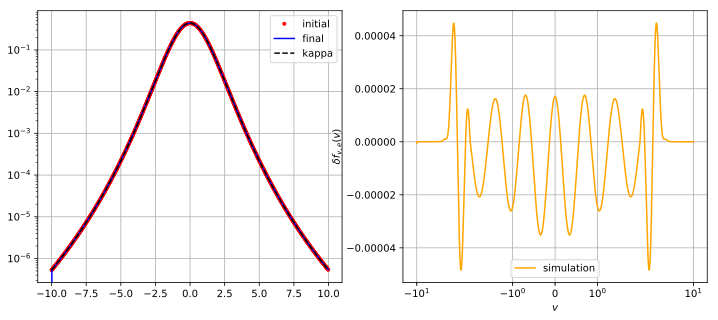

In [410]:
vstart = -vmax
vend = vmax
nvs = int((vstart + vmax ) / dv)
nve = int((vend + vmax) /dv)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v[nvs:nve],fv0[nvs:nve],'.',color='r',label='initial')
ax1.plot(v[nvs:nve],fv[nvs:nve],color='blue',label='final')
ax1.plot(v[nvs:nve],fk(v[nvs:nve],tem,kappa),'--',color='black',label='kappa')
ax1.set_yscale('log')

ax2.plot(v, fv-fv0, color='orange', label='simulation')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\delta f_{v,e}(v)$')
ax2.set_xscale('symlog')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 密度&温度分布

$$ \frac{n(x)}{n_0}=\left[ \frac{T(x)}{T_0} \right]^{-\kappa_0-1}$$
$$ \nabla \ln T = - \frac{1}{\kappa_0+1} \nabla \ln n$$

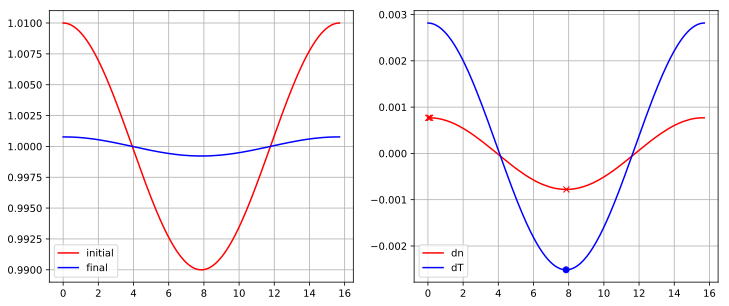

In [411]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(x,fx0,color='r',label='initial')
ax1.plot(x,fx,color='blue',label='final')

dn = fx - 1
dT = T - 1
dn_maxidx, _ = signal.find_peaks(dn, distance=5)
dn_minidx, _ = signal.find_peaks(-dn, distance=5)
dT_maxidx, _ = signal.find_peaks(dT, distance=5)
dT_minidx, _ = signal.find_peaks(-dT, distance=5)

ax2.plot(x,dn,color='r',label='dn')
ax2.plot(x[dn_maxidx[0:2]],dn[dn_maxidx[0:2]],'x',color='r')
ax2.plot(x[dn_minidx[0:2]],dn[dn_minidx[0:2]],'x',color='r')

ax2.plot(x,dT,color='blue',label='dT')
ax2.plot(x[dT_maxidx[0:2]],dT[dT_maxidx[0:2]],'o',color='blue')
ax2.plot(x[dT_minidx[0:2]],dT[dT_minidx[0:2]],'o',color='blue')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

In [412]:
#dn_A = np.mean(dn[dn_maxidx[0:4]]-dn[dn_minidx[0:4]])
#dT_A = np.mean(dT[dT_maxidx[0:4]]-dT[dT_minidx[0:4]])
dn_A = dn[0]-dn[nx//2]
dT_A = dT[0]-dT[nx//2]
print(dT_A/dn_A)

3.4454620810696612


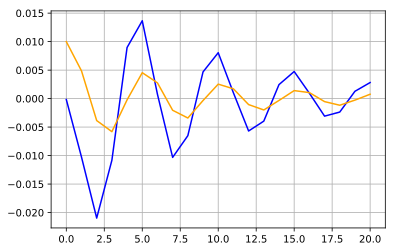

In [413]:
dn_x0 = np.array(n_x0) - 1
dT_x0 = np.array(T_x0) - tem
plt.plot(progesses,dT_x0,color='blue')
plt.plot(progesses,dn_x0,color='orange')
plt.grid()
plt.show()